# Binary classification of machine failures

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/Abandoned_concrete_factory_mechanism.jpg/320px-Abandoned_concrete_factory_mechanism.jpg)

## Introduction 📜

The goal of this notebook is to analyse data about machine failures and their attributes at the point of failure and then develop a model to predict future failures of these machine units. The data is synthetically generated by a deep learning model trained on the following data set https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions .

## Libaries 🗃️

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import math
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Loading data 💾

In [ ]:
training_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

## Data exploration 🔭

### Manual inspection
As a first step the data is manually inspected to see possible trends, problems, etc.

In [3]:
training_data.head(5)

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.600,309.600,1596,36.100,140,0,0,0,0,0,0
1,1,M20343,M,302.600,312.100,1759,29.100,200,0,0,0,0,0,0
2,2,L49454,L,299.300,308.500,1805,26.500,25,0,0,0,0,0,0
3,3,L53355,L,301.000,310.900,1524,44.300,197,0,0,0,0,0,0
4,4,M24050,M,298.000,309.000,1641,35.400,34,0,0,0,0,0,0


A first look at the range, mean etc of the different features.

In [4]:
training_data.drop(columns=['id', 'Product ID', 'Machine failure']).describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
count,136429.000,136429.000,136429.000,136429.000,136429.000,136429.000,136429.000,136429.000,136429.000,136429.000
mean,299.863,309.941,1520.331,40.349,104.409,0.002,0.005,0.002,0.004,0.002
std,1.862,1.385,138.737,8.502,63.965,0.039,0.072,0.049,0.063,0.047
min,295.300,305.800,1181.000,3.800,0.000,0.000,0.000,0.000,0.000,0.000
25%,298.300,308.700,1432.000,34.600,48.000,0.000,0.000,0.000,0.000,0.000
50%,300.000,310.000,1493.000,40.400,106.000,0.000,0.000,0.000,0.000,0.000
75%,301.200,310.900,1580.000,46.100,159.000,0.000,0.000,0.000,0.000,0.000
max,304.400,313.800,2886.000,76.600,253.000,1.000,1.000,1.000,1.000,1.000


The features "Air temperature" and "Process temperature" have a rather small standard deviation and min/max values are pretty close together compared to the other numerical features. This raises the question whether they might play a smaller role in the machine failure than the other features. 

It also looks like there are no missing values in any column which checks out.

In [5]:
training_data.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

The last 5 features are binary ...

In [6]:
pd.unique(training_data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].values.ravel('K'))

array([0, 1])

In [7]:
training_data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].drop_duplicates().head(5)

,TWF,HDF,PWF,OSF,RNF
0,0,0,0,0,0
164,0,1,0,0,0
236,0,0,0,1,0
313,0,0,0,0,1
385,0,0,1,1,0


... and come in a sort of hot encoded form with multi-variant. Whereas the "Type" is a categorical feature with 3 different

In [8]:
training_data[['Type']].drop_duplicates()

,Type
0,L
1,M
26,H


Whereas the "Type" is a categorical feature with 3 different possible values. This feature will be also one-hot-encoded later.

In [9]:
training_data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].nunique()

Air temperature [K]         95
Process temperature [K]     81
Rotational speed [rpm]     952
Torque [Nm]                611
Tool wear [min]            246
dtype: int64

Quiet some of the "measurement" features are duplicated which you would normally not expect for such measured values in the real world. The values have no decimal precision which increases chances for duplicates and the synthetical origin might also play a role. However, compared to the total number of 136429 values these numbers are negligible.

As a last step lets check the balance of the failure feature. The percentage of data points with machine failure is really small which leads to an  inbalanced training set.

In [10]:
number_fail = training_data[training_data['Machine failure'] == 1]['Machine failure'].count()
number_no_fail = training_data[training_data['Machine failure'] == 0]['Machine failure'].count()
print("Failure: ", number_fail)
print("No failure: ", number_no_fail)
print(f"Failure percentage: {((number_fail / number_no_fail) * 100):.4f}% ")

Failure:  2148
No failure:  134281
Failure percentage: 1.5996% 


### Visual exploration
To get a feeling how the values of the different features are distributed and correlated plots are used

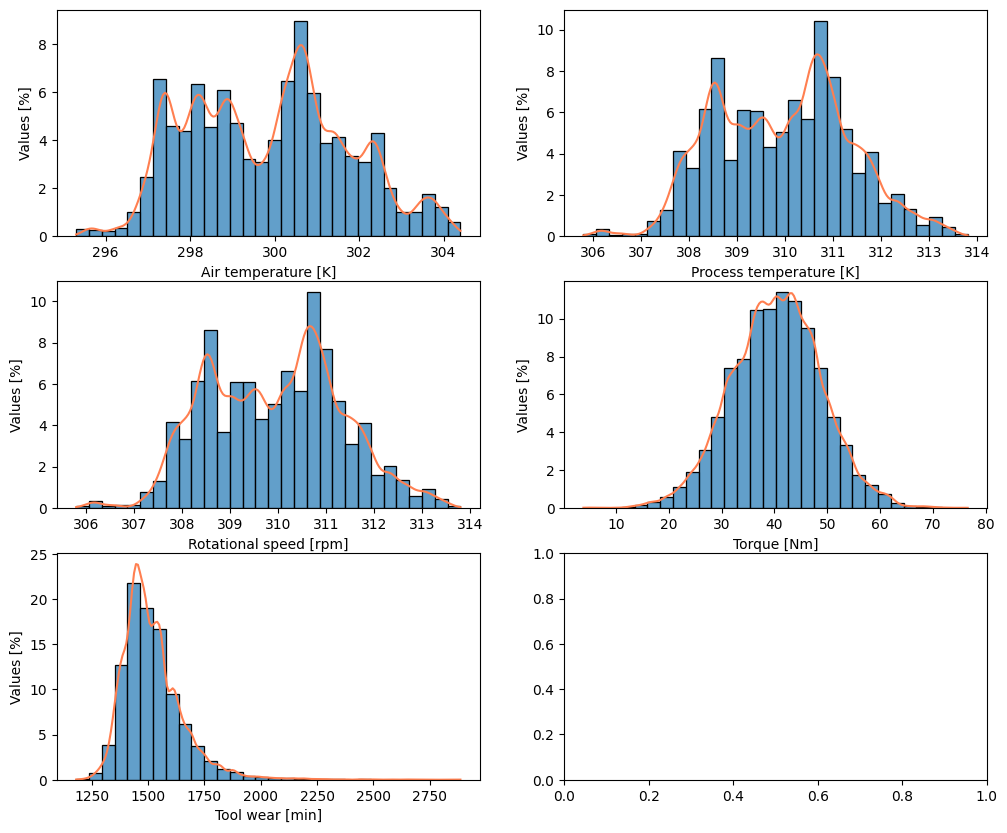

In [11]:
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
feature_num = len(features)
col_num = 2
row_num = math.ceil(feature_num / col_num)

fig, axs = plt.subplots(nrows=row_num, ncols=col_num)
fig.set_figwidth(12)
fig.set_figheight(10)

plots_histo = []

for r in range(row_num):
    for c in range(col_num):
        feat = (c + 1) * (r + 1)
        if feature_num > feat:
            plots_histo.append(sb.histplot(data=training_data[features[feat-1]], 
                               bins=30, alpha=0.7, kde=True, stat='percent', line_kws={'color': "red", 'lw': 1.5, 'ls': '-'}, ax=axs[r, c]))

for hg, label in zip(plots_histo, features):
    hg.set(xlabel=label, ylabel='Values [%]')
    hg.lines[0].set_color('coral')

plt.show()

From the diagrams it is appearent that torque and tool wear have a bell like distribution while the other three measurement's values are more widely spread. Like written before the values in these three measured parameters also range over a small space if set into relation to the mean value and the lower/upper border.

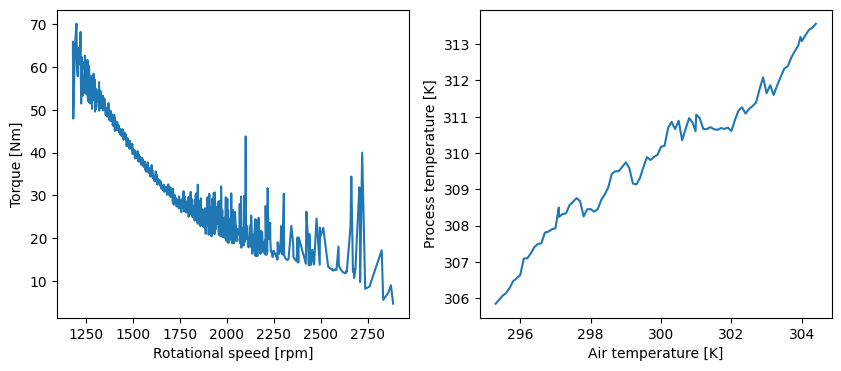

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(4)

features = [('Rotational speed [rpm]', 'Torque [Nm]'), ('Air temperature [K]', 'Process temperature [K]')]
plots_line = []

for i, feat in enumerate(features):
    plots_line.append(sb.lineplot(data=training_data, x=feat[0], y=feat[1], errorbar=None, ax=axs[i]))

for hg, label in zip(plots_line, features):
    hg.set(xlabel=label[0], ylabel=label[1])
    
plt.show()

From a logical and physical point of view it only makes sense that two measurement pairs have a correlation which are Torque/Rotation and the two temperatures. These are shown in the two graphs.

### Algorithmic inspection
Too further inspect the data. In the following principal component analysis is used to reduce the data dimensions and make conclusions about the variance of the resulting features. On the dimension reduced data a clustering algorithm, k-means, will be applied to check whether there is a clear cluster separation.

First the feature 'Type' needs to be one-hot-encoded as it currently has strings as content.

In [13]:
pca_data = training_data.copy(deep=True)
pca_data = pca_data.drop(columns=['id', 'Product ID', 'Machine failure'])
pca_data = pd.get_dummies(data=pca_data, columns=['Type'])
pca_data.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF', 'Type_H', 'Type_L', 'Type_M'],
      dtype='object')

Then a standard scaler is selectively applied to only the numerical features while the categorical features are left untouched.

In [14]:
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                    'Torque [Nm]', 'Tool wear [min]']

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ], remainder='passthrough'
)

pca_data_scaled = pd.DataFrame(preprocessor.fit_transform(pca_data))

In [15]:
pca_data_scaled.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.396,-0.246,0.545,-0.500,0.556,0,0,0,0,0,False,True,False
1,1.470,1.559,1.720,-1.323,1.494,0,0,0,0,0,False,False,True
2,-0.302,-1.040,2.052,-1.629,-1.241,0,0,0,0,0,False,True,False


On this scaled data now PCA is applied. First without any principal component count to check how large the explained variance ratios are and how the cummulated variance grows with increasing component count.

In [16]:
pca = PCA(random_state=42)
pca.fit(pca_data_scaled)

PCA(random_state=42)

In [17]:
pc_count = np.arange(pca.n_components_) + 1
cummulated_ratios = [0] * (pca.n_components_ + 1)
explained_variance_ratio = pca.explained_variance_ratio_
variance_plot_data = pd.DataFrame(index=pc_count, columns=['variance_ratio', 'variance_cumulated'])

for i, ratio in enumerate(explained_variance_ratio):
    if i != 0:
        cummulated_ratios[i] = ratio + cummulated_ratios[i-1]
    else:
        cummulated_ratios[0] = ratio

for i, ratio in enumerate(cummulated_ratios):
    variance_plot_data['variance_cumulated'][i+1] = ratio
    variance_plot_data['variance_ratio'][i] = explained_variance_ratio[i-1]

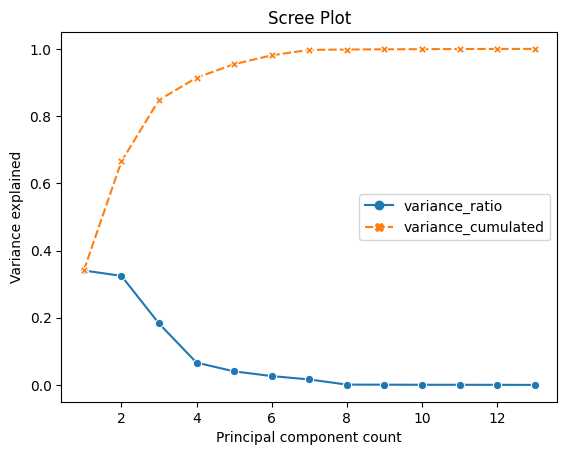

In [18]:
sb.lineplot(data=variance_plot_data, markers=True, errorbar=None, color='coral')
plt.title('Scree Plot')
plt.xlabel('Principal component count')
plt.ylabel('Variance explained')
plt.show()

The two first principal components already explain approx. 70% of the total variability of the data. We take these two for k-means clustering to check whether there are clear groups. When we later use the dimension reduced date for training the model we likely stick to 4 principal components with a higher explained variance of 90%, 

In [19]:
pca_two_comp = PCA(random_state=42, n_components=2)
pca_two_comp.fit(pca_data_scaled)
data_pca_transformed = pca_two_comp.transform(pca_data_scaled)

The PCA transformed data is then clustered to check whether there are clear clusters to recognize in the data. We use two clusters as the number of labels is already know. (failure or no failure)

In [20]:
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans.fit(data_pca_transformed)
labels_data = kmeans.predict(data_pca_transformed)

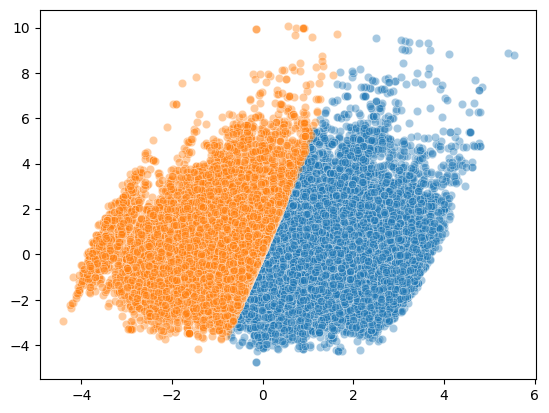

In [21]:
points_label1 = data_pca_transformed[labels_data == 0]
points_label2 = data_pca_transformed[labels_data == 1]
 
sb.scatterplot(x=points_label1[:,0] , y=points_label1[:,1], alpha=0.4)
sb.scatterplot(x=points_label2[:,0] , y=points_label2[:,1], alpha=0.4)
plt.show()

When examining the scatter plot of the clustering with k-means and the two principal components there is no clear boundary or recognizable clusters. This might be an indicator that distance driven learning algorithms like k-nearest-neighbours are unsuited here.

## Building the pipe and modelling 🛠️

In [34]:
X = training_data.drop(columns=['id', 'Machine failure', 'Product ID'])
y = training_data[['Machine failure']]

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

First a pipeline is build with scaling, one-hot-encoding and principal component reduction is defined.

In [36]:
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                    'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor_pipe = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ], remainder='passthrough'
)

pca_pipe = Pipeline(
    steps=[("preprocessor", preprocessor_pipe), ("pca", PCA(n_components=5, random_state=42))]
)

Then three different classifiers are added to the pipeline to compare.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

classifiers = [("log_reg", LogisticRegression(random_state=42)), 
               ("forest_reg", RandomForestClassifier(random_state=42)),
               ("sgd_clsf", SGDClassifier(random_state=42, loss='log_loss'))]

classifier_pipes = []

for clsf in classifiers:
    classifier_pipes.append(Pipeline(steps=[('dim_reduct', pca_pipe), clsf]))

classifier_pipes[1]

Pipeline(steps=[('dim_reduct',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Air '
                                                                    'temperature '
                                                                    '[K]',
                                                                    'Process '
                                                                    'temperature '
                                                                    '[K]',
                                                                    'Rotational '
                                                                    'speed '
                                                                    '[rpm]',
                                                                    'Torque '
                                                                    '[Nm]',
                                                                    'Tool wear '
                                                                    '[min]']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Type'])])),
                                 ('pca',
                                  PCA(n_components=5, random_state=42))])),
                ('forest_reg', RandomForestClassifier(random_state=42))])

In [38]:
from sklearn.model_selection import cross_val_score


for pipe in classifier_pipes:
    scores = cross_val_score(pipe, X_train, y_train.values.ravel(), cv=3)
    print("Cross-validation scores: ", scores)
    
for pipe in classifier_pipes:
    pipe.fit(X_train, y_train.values.ravel())
    print("model score: %.3f" % pipe.score(X_valid, y_valid.values.ravel()) )

model score: 0.985
model score: 0.986
model score: 0.984


The prediction scores for the three models do not differ so much. But then looking at the ROC scores the random forest classifier clearly outperforms the other two models.

In [39]:
from sklearn.metrics import roc_auc_score

for pipe in classifier_pipes:
    y_scores = pipe.predict_proba(X_valid)
    weighted_roc_auc_ovr = roc_auc_score(
        y_valid.values.ravel(),
        y_scores[:, 1].ravel(),
        multi_class="ovo",
        average="weighted"
    )
    
    print(pipe[1])
    print(f"Weighted One-vs-Rest ROC AUC score:\n{weighted_roc_auc_ovr:.2f}")

LogisticRegression(random_state=42)
Weighted One-vs-Rest ROC AUC score:
0.81
RandomForestClassifier(random_state=42)
Weighted One-vs-Rest ROC AUC score:
0.90
SGDClassifier(loss='log_loss', random_state=42)
Weighted One-vs-Rest ROC AUC score:
0.81
